In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
words = open('../names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
char2idx = {s:i+1 for i,s in enumerate(chars)}
char2idx['.'] = 0
idx2char = {i:s for s,i in char2idx.items()}
print(idx2char)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset
X = []
Y = []

block_size = 3 # Hyper-parameter for context length: how many characters do we take to predict the next one?
for w in words[:5]:
    chrs = (block_size) * ['.'] + list(w)
    for i in range(len(chrs) - block_size + 1):
        X.append([char2idx[c] for c in chrs[i: i + block_size]])
        idx = char2idx[chrs[i + block_size]] if i + block_size < len(chrs) else char2idx['.']
        Y.append(idx)

X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
embedding_dim = 2
C = torch.randn(27, embedding_dim) # Embedding matrices denoted as C in the paper.
C # Each character possesses two features.

tensor([[ 1.1808,  0.9664],
        [-0.1551, -1.6788],
        [-0.9211, -0.7622],
        [ 0.9402, -2.9359],
        [ 0.8507, -0.8136],
        [-0.8458, -0.2785],
        [ 1.1833, -0.6928],
        [-1.6040, -1.1741],
        [ 0.9288,  0.5720],
        [ 0.1116,  0.0427],
        [ 1.9102,  0.3926],
        [-0.5713,  0.1444],
        [ 0.0515,  1.2955],
        [-0.4930, -0.3827],
        [-0.0575, -0.9240],
        [-0.3734, -0.6004],
        [-0.4183, -2.3458],
        [-1.3488, -0.5878],
        [-0.1250, -1.1005],
        [ 1.0250, -0.4665],
        [ 2.1382, -2.1478],
        [ 0.6013, -1.1904],
        [ 0.1499,  1.5670],
        [ 0.9119, -0.6861],
        [ 0.2352,  0.1070],
        [ 1.1419, -0.7843],
        [ 1.2273,  1.6142]])

In [8]:
# First method involves one-hot encoding and matrix multiplication.
F.one_hot(X[0], num_classes=27).shape

torch.Size([3, 27])

In [9]:
C.shape

torch.Size([27, 2])

In [10]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.8458, -0.2785])

In [11]:
# Second method involves indexing C matrices, essentially equivalent to the first approach.
idx = 5
emd = C[5]
emd

tensor([-0.8458, -0.2785])

In [12]:
hidden_layer = 100
W1 = torch.randn(embedding_dim * block_size, hidden_layer) # embedding_dim * block_size is the number of parameter for each example
b1 = torch.randn(hidden_layer)

In [13]:
emd = C[X]
emd.shape

torch.Size([32, 3, 2])

In [14]:
W1.shape

torch.Size([6, 100])

In [15]:
torch.cat([emd[:,0,:], emd[:,1,:], emd[:, 2, :]], 1).shape # Not very efficient or scalable.

torch.Size([32, 6])

In [16]:
torch.cat(torch.unbind(emd, dim=1), 1).shape  # Removing a tensor dimension, still not the optimal choice.

torch.Size([32, 6])

In [17]:
emd.view(-1, embedding_dim * block_size).shape # The size -1 is inferred from other dimensions.

torch.Size([32, 6])

In [18]:
b1.shape

torch.Size([100])

In [19]:
h = F.tanh(emd.view(-1, embedding_dim * block_size) @ W1 + b1)

In [20]:
h.shape # batch size X hidden layer dim

torch.Size([32, 100])

In [21]:
W2 = torch.randn(hidden_layer, len(char2idx)) # Output probability for each character.
b2 = torch.randn(len(char2idx))
W2.shape

torch.Size([100, 27])

In [22]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [23]:
# One approach for obtaining probabilities, as demonstrated earlier.
counts = torch.exp(logits)
fw_prob = counts / counts.sum(1, keepdims=True)
fw_prob[0].sum()

tensor(1.)

In [24]:
# Improved method using Torch's softmax implementation for obtaining probabilities.
prob = F.softmax(logits, dim=1).float()
prob[0].sum()

tensor(1.0000)

In [25]:
prob[0]

tensor([6.7923e-05, 1.0958e-13, 6.8578e-10, 9.5173e-12, 1.2879e-09, 3.2482e-08,
        5.9869e-11, 4.6997e-11, 1.3692e-08, 5.5025e-02, 2.6337e-13, 2.8230e-10,
        3.4067e-09, 1.4927e-07, 1.7372e-14, 1.1943e-05, 1.8880e-10, 3.0827e-10,
        5.5493e-05, 1.0402e-09, 9.4425e-01, 1.4988e-12, 1.5955e-16, 1.1524e-13,
        3.9408e-04, 1.9286e-04, 6.4276e-08])

In [26]:
fw_prob[0] 

tensor([6.7923e-05, 1.0958e-13, 6.8578e-10, 9.5173e-12, 1.2879e-09, 3.2482e-08,
        5.9869e-11, 4.6997e-11, 1.3692e-08, 5.5025e-02, 2.6337e-13, 2.8230e-10,
        3.4067e-09, 1.4927e-07, 1.7372e-14, 1.1943e-05, 1.8880e-10, 3.0827e-10,
        5.5493e-05, 1.0402e-09, 9.4425e-01, 1.4988e-12, 1.5955e-16, 1.1524e-13,
        3.9408e-04, 1.9286e-04, 6.4276e-08])

In [27]:
X.shape[0]

32

In [28]:
# Manual implementation of the loss function
loss = -prob[torch.arange(X.shape[0]), Y].log().mean()
loss

tensor(12.5616)

In [29]:
# Loss function implemented using cross-entropy 
loss = F.cross_entropy(logits, Y)
loss

tensor(12.5616)

In [30]:
# Utilize PyTorch's built-in functions for better efficiency
# Improved forward pass, avoiding new tensor creation
# Enhanced backward pass with direct calculation, improving efficiency
# Overall, more numerically efficient


In [31]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [32]:
C = torch.randn(27, embedding_dim)
W1 = torch.randn(embedding_dim * block_size, hidden_layer) # embedding_dim * block_size is the number of parameter for each example
b1 = torch.randn(hidden_layer)
W2 = torch.randn(hidden_layer, len(char2idx)) # output propabily for each char
b2 = torch.randn(len(char2idx))
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)

3481

In [33]:
# Let's train
lr = 0.1
for p in parameters:
    p.requires_grad = True

for _ in range(100):
    # forward pass
    emd = C[X] # (32, 3, 2)
    h = F.tanh(emd.view(-1, embedding_dim * block_size) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parametrs
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())
    


0.3264015316963196


In [34]:
# Facing overfitting with a small dataset (only 32 samples)
# Challenge in reaching loss=0 due to varied targets for each '...' example
logits.max(1)

torch.return_types.max(
values=tensor([ 8.2522,  9.3012, 10.2504,  7.2955, 12.5157,  8.2522, 12.6247, 11.2400,
        11.5065, 13.8197, 17.1205, 14.9500,  8.2522, 12.6599, 12.5141, 12.2135,
         8.2522, 13.7327, 15.8803, 14.6567, 18.4300, 12.2214, 15.6800, 10.6811,
        14.9392,  8.2522, 16.8662, 15.4013, 10.9107, 14.8508, 12.0538, 15.2189],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1, 13, 13,  1,  0,  1, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  1, 19,
         1,  2,  5, 12, 12,  1,  0,  1, 15, 16,  8,  9,  1,  0]))

In [35]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [36]:
# Let's train over the whole dataset while using batches
# build the dataset
X = []
Y = []

block_size = 3 # Hyper-parameter for context length: how many characters do we take to predict the next one?
for w in words:
    chrs = (block_size) * ['.'] + list(w)
    for i in range(len(chrs) - block_size + 1):
        X.append([char2idx[c] for c in chrs[i: i + block_size]])
        idx = char2idx[chrs[i + block_size]] if i + block_size < len(chrs) else char2idx['.']
        Y.append(idx)

X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [37]:
C = torch.randn(len(char2idx), embedding_dim)
W1 = torch.randn(embedding_dim * block_size, hidden_layer) # embedding_dim * block_size is the number of parameter for each example
b1 = torch.randn(hidden_layer)
W2 = torch.randn(hidden_layer, len(char2idx)) # Output probability for each character
b2 = torch.randn(len(char2idx))
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)

3481

In [38]:
# Let's train
lr = 0.1
for p in parameters:
    p.requires_grad = True

for _ in range(1_000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,)) # batch size of 32
    # forward pass
    emd = C[X[ix]] # (32, 3, 2)
    h = F.tanh(emd.view(-1, embedding_dim * block_size) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parametrs
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())

2.7184481620788574


In [39]:
# finding a descent learning rate
lrs = 10**torch.linspace(-3, 0, 1000)

lri = []
lossi = []
stepi = []

for p in parameters:
    p.requires_grad = True

for i in range(1_000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,)) # batch size of 32
    # forward pass
    emd = C[X[ix]] # (32, 3, 2)
    h = F.tanh(emd.view(-1, embedding_dim * block_size) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parametrs
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    #track stats
    lri.append(lr)
    lossi.append(loss.item())


In [41]:
C = torch.randn(len(char2idx), embedding_dim)
W1 = torch.randn(embedding_dim * block_size, hidden_layer) # embedding_dim * block_size is the number of parameter for each example
b1 = torch.randn(hidden_layer)
W2 = torch.randn(hidden_layer, len(char2idx)) # Output probability for each character
b2 = torch.randn(len(char2idx))
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)

3481

In [42]:
def build_dataset(words): 
    X = []
    Y = []
    
    for w in words:
        chrs = (block_size) * ['.'] + list(w)
        for i in range(len(chrs) - block_size + 1):
            X.append([char2idx[c] for c in chrs[i: i + block_size]])
            idx = char2idx[chrs[i + block_size]] if i + block_size < len(chrs) else char2idx['.']
            Y.append(idx)
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.shuffle(words)
# split the data to 80% training, 10% validation, 10% testing
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182341, 3]) torch.Size([182341])
torch.Size([23015, 3]) torch.Size([23015])
torch.Size([22790, 3]) torch.Size([22790])


In [43]:
# Adding lr decay and train only on Xtr
lossi = []
stepi = []
for p in parameters:
    p.requires_grad = True

for i in range(30_000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # batch size of 32
    # forward pass
    emd = C[Xtr[ix]] 
    h = F.tanh(emd.view(-1, embedding_dim * block_size) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parametrs
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    lossi.append(loss.log10().item())
    stepi.append(i)

In [44]:
emd = C[Xtr]

h = F.tanh(emd.view(-1, embedding_dim * block_size) @ W1 + b1)
print(h.shape)
logits = h @ W2 + b2 
print(logits.shape)
loss = F.cross_entropy(logits, Ytr)
loss

torch.Size([182341, 100])
torch.Size([182341, 27])


tensor(2.3877, grad_fn=<NllLossBackward0>)

In [45]:
# evaluating the results
emd = C[Xval] # (32, 3, 2)
h = F.tanh(emd.view(-1, embedding_dim * block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yval)
loss


tensor(2.3854, grad_fn=<NllLossBackward0>)

In [46]:
# Similar loss in both training and validation indicates underfitting
# To address this, consider enhancing model complexity by adjusting hyperparameters


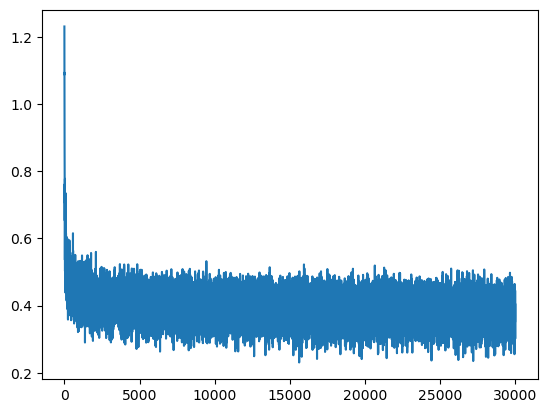

In [47]:
plt.plot(stepi, lossi)

In [48]:
# The noise (thicknes) stems from the batch which adds noise to the optimization on account of speed

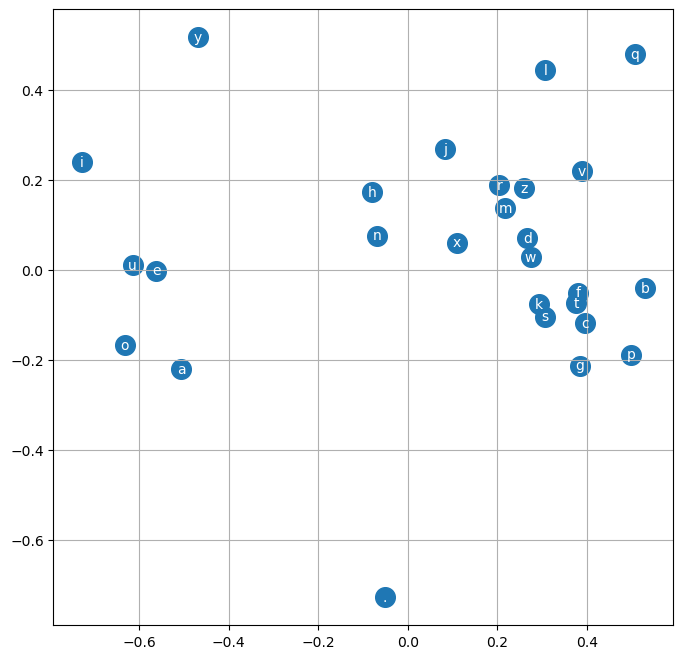

In [50]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), idx2char[i], ha="center", va="center", color='white')
plt.grid('minor')

In [51]:
# It seems like there is some learning proccess in the embedding metrics

In [52]:
block_size = 3
hidden_layer = 200
embedding_dim = 10

In [53]:
C = torch.randn(27, embedding_dim)
W1 = torch.randn(embedding_dim * block_size, hidden_layer) # embedding_dim * block_size is the number of parameter for each example
b1 = torch.randn(hidden_layer)
W2 = torch.randn(hidden_layer, len(char2idx)) # output propabily for each char
b2 = torch.randn(len(char2idx))
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)

11897

In [54]:
lossi = []
stepi = []
for p in parameters:
    p.requires_grad = True

for i in range(50_000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # batch size of 32
    # forward pass
    emd = C[Xtr[ix]] 
    h = F.tanh(emd.view(-1, embedding_dim * block_size) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parametrs
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    lossi.append(loss.log10().item())
    stepi.append(i)

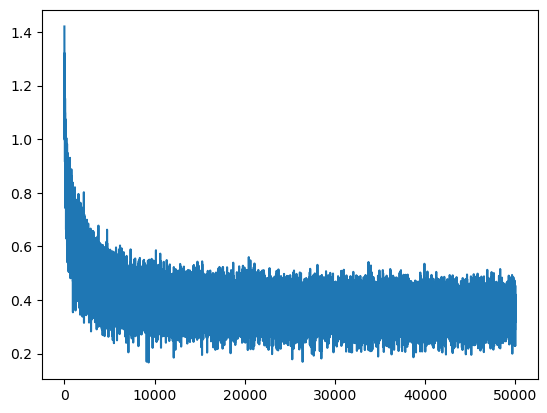

In [55]:
plt.plot(stepi, lossi)

In [56]:
emd = C[Xtr]

h = F.tanh(emd.view(-1, embedding_dim * block_size) @ W1 + b1)
print(h.shape)
logits = h @ W2 + b2 
print(logits.shape)
loss = F.cross_entropy(logits, Ytr)
loss

torch.Size([182341, 200])
torch.Size([182341, 27])


tensor(2.2924, grad_fn=<NllLossBackward0>)

In [57]:
# evaluating the results
emd = C[Xval] # (32, 3, 2)
h = F.tanh(emd.view(-1, embedding_dim * block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.3190, grad_fn=<NllLossBackward0>)

In [58]:
# Divergence in training and validation loss suggests potential overfitting


In [59]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d) only working with single dim
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(idx2char[i] for i in out))

milynn.
ezma.
salaylie.
yuodlyn.
elrene.
lyn.
reilaedyn.
vackes.
lenr.
eulia.
happionnandingenj.
walle.
nakan.
eveimoniadyneens.
genmaraalyn.
ine.
manzeyano.
hean.
lul.
leas.
